### YPLL

In [1]:
setwd("C:\\Users\\SROY\\Desktop\\Courses\\Applied Stats\\Project")
rm(list=ls())
seedVal = 17869
options(warn=-1)
options(scipen=999)

In [19]:
# Libraries
library(ggplot2)
library(ggcorrplot)
library(dummies)
library(rms)

Loading required package: Hmisc
Loading required package: lattice
Loading required package: survival
Loading required package: Formula

Attaching package: 'Hmisc'

The following objects are masked from 'package:base':

    format.pval, round.POSIXt, trunc.POSIXt, units

Loading required package: SparseM

Attaching package: 'SparseM'

The following object is masked from 'package:base':

    backsolve



In [3]:
measures <- read.csv2("additional_measures_cleaned.csv", header = TRUE, sep = ',')
ypll <- read.csv2("ypll.csv", header = TRUE, sep = ',')

In [4]:
head(measures)

FIPS,State,County,Population,X..18,X65.and.over,African.American,Female,Rural,X.Diabetes,HIV.rate,Physical.Inactivity,mental.health.provider.rate,median.household.income,X..high.housing.costs,X..Free.lunch,X..child.Illiteracy,X..Drive.Alone
1000,Alabama,,4708708,23.9,13.8,26.1,51.6,44.6,12,NA,31,20,42586,30,51,14.8,84
1001,Alabama,Autauga,50756,27.8,11.6,18.4,51.4,44.8,11,170,33,2,51622,25,29,12.7,86
1003,Alabama,Baldwin,179878,23.1,17,10,51,54.2,10,176,25,17,51957,29,29,10.6,83
1005,Alabama,Barbour,29737,22.3,13.8,46.6,46.8,71.5,14,331,35,7,30896,36,65,23.2,82
1007,Alabama,Bibb,21587,23.3,13.5,22.3,48,81.5,11,90,37,0,41076,18,48,17.5,83
1009,Alabama,Blount,58345,24.2,14.7,2.1,50.2,91,11,66,35,2,46086,21,37,13.9,80


In [5]:
head(ypll)

FIPS,State,County,Unreliable,YPLL.Rate
1000,Alabama,,,10189
1001,Alabama,Autauga,,9967
1003,Alabama,Baldwin,,8322
1005,Alabama,Barbour,,9559
1007,Alabama,Bibb,,13283
1009,Alabama,Blount,,8475


In [6]:
df <- merge(x = ypll, y = measures, by.x = c("FIPS"), by.y = c("FIPS"))

In [7]:
apply(df, 2, function(x) length(which(x == "" | is.na(x) | x == "NA")))

FIPS                     State.x 
                          0                           0 
                   County.x                  Unreliable 
                         51                        2996 
                  YPLL.Rate                     State.y 
                         95                           0 
                   County.y                  Population 
                         51                           0 
                      X..18                X65.and.over 
                          0                           0 
           African.American                      Female 
                          0                           0 
                      Rural                  X.Diabetes 
                          1                           0 
                   HIV.rate         Physical.Inactivity 
                        962                           0 
mental.health.provider.rate     median.household.income 
                          0                           1 
      X..high.housing.costs               X..Free.lunch 
                          0                          19 
        X..child.Illiteracy              X..Drive.Alone 
                          6                           0

In [8]:
# remove records that are unreliable
df <- df[df$Unreliable != 'x',names(df) != 'Unreliable']
# Remove cumulative records
df <- df[df$County.x != '',]
# Remove missing YPLL rate as it does not add value and 
# doesn't make sense to impute it as it is the target variable
df <- df[!is.na(df$YPLL.Rate),]
# Remove missing Rural, X.free.lunch and X..chile.Illiteracy as they are few
# removing 1 rural also removes free lunch and child illiteracy 
df <- df[!df$Rural == '',]
df <- df[!df$X..child.Illiteracy == '',]
df <- df[!is.na(df$X..Free.lunch),]

In [9]:
apply(df, 2, function(x) length(which(x == "" | is.na(x) | x == "NA")))

FIPS                     State.x 
                          0                           0 
                   County.x                   YPLL.Rate 
                          0                           0 
                    State.y                    County.y 
                          0                           0 
                 Population                       X..18 
                          0                           0 
               X65.and.over            African.American 
                          0                           0 
                     Female                       Rural 
                          0                           0 
                 X.Diabetes                    HIV.rate 
                          0                         625 
        Physical.Inactivity mental.health.provider.rate 
                          0                           0 
    median.household.income       X..high.housing.costs 
                          0                           0 
              X..Free.lunch         X..child.Illiteracy 
                          0                           0 
             X..Drive.Alone 
                          0

In [10]:
# HIV rate is an important predictor. but 22% values are missing
# so it is difficult to impute
# we can bucket it into categories
HIVRate <- df[!is.na(df$HIV.rate),'HIV.rate']
range(HIVRate)
quantile(HIVRate)

df$HIV <- cut(df$HIV.rate, breaks = c(-Inf, 57, 98, 194, Inf), 
              labels = c("VeryLow","Low","High","VeryHigh"))
df[is.na(df$HIV),'HIV'] <- 'NotAvail'

[1]   13 4534

0%  25%  50%  75% 100% 
  13   57   98  194 4534

In [11]:
# Remove irrelevant columns
names(df)
excludeList <- c("FIPS", "State.x", "State.y", "County.x", "County.y", "HIV.rate")
includeList <- names(df[!names(df) %in% c(excludeList)])
df <- df[,includeList]

[1] "FIPS"                        "State.x"                    
 [3] "County.x"                    "YPLL.Rate"                  
 [5] "State.y"                     "County.y"                   
 [7] "Population"                  "X..18"                      
 [9] "X65.and.over"                "African.American"           
[11] "Female"                      "Rural"                      
[13] "X.Diabetes"                  "HIV.rate"                   
[15] "Physical.Inactivity"         "mental.health.provider.rate"
[17] "median.household.income"     "X..high.housing.costs"      
[19] "X..Free.lunch"               "X..child.Illiteracy"        
[21] "X..Drive.Alone"              "HIV"

In [12]:
# Change factors to numeric
df$X..18 <- as.numeric(as.character(df$X..18))
df$X65.and.over <- as.numeric(as.character(df$X65.and.over))
df$African.American <- as.numeric(as.character(df$African.American))
df$Female <- as.numeric(as.character(df$Female))
df$Rural <- as.numeric(as.character(df$Rural))
df$X..child.Illiteracy <- as.numeric(as.character(df$X..child.Illiteracy))
str(df)
summary(df)

'data.frame':	2834 obs. of  16 variables:
 $ YPLL.Rate                  : int  9967 8322 9559 13283 8475 15433 12652 11720 11319 11753 ...
 $ Population                 : int  50756 179878 29737 21587 58345 10985 19964 114081 34320 24448 ...
 $ X..18                      : num  27.8 23.1 22.3 23.3 24.2 24.6 24.8 23.4 22.5 20.9 ...
 $ X65.and.over               : num  11.6 17 13.8 13.5 14.7 10.8 16.2 15 16.8 18.6 ...
 $ African.American           : num  18.4 10 46.6 22.3 2.1 68.2 41.9 20 37.8 5.6 ...
 $ Female                     : num  51.4 51 46.8 48 50.2 44.5 52.9 52.1 52.6 51.4 ...
 $ Rural                      : num  44.8 54.2 71.5 81.5 91 64.7 74.8 31 49.8 100 ...
 $ X.Diabetes                 : int  11 10 14 11 11 15 15 15 16 14 ...
 $ Physical.Inactivity        : int  33 25 35 37 35 32 35 32 36 37 ...
 $ mental.health.provider.rate: int  2 17 7 0 2 0 5 11 3 0 ...
 $ median.household.income    : int  51622 51957 30896 41076 46086 26980 31449 39997 35614 38028 ...
 $ X..high.housi

   YPLL.Rate       Population          X..18        X65.and.over  
 Min.   : 3275   Min.   :   1485   Min.   :11.30   Min.   : 2.60  
 1st Qu.: 6696   1st Qu.:  14371   1st Qu.:21.60   1st Qu.:12.70  
 Median : 8146   Median :  29840   Median :23.50   Median :15.00  
 Mean   : 8461   Mean   : 107552   Mean   :23.64   Mean   :15.18  
 3rd Qu.: 9934   3rd Qu.:  75279   3rd Qu.:25.30   3rd Qu.:17.30  
 Max.   :24829   Max.   :9848011   Max.   :40.50   Max.   :34.30  
 African.American     Female          Rural          X.Diabetes   
 Min.   : 0.000   Min.   :25.10   Min.   :  0.00   Min.   : 3.00  
 1st Qu.: 0.900   1st Qu.:49.80   1st Qu.: 33.50   1st Qu.: 9.00  
 Median : 2.900   Median :50.60   Median : 56.85   Median :10.00  
 Mean   : 9.867   Mean   :50.23   Mean   : 56.09   Mean   :10.01  
 3rd Qu.:11.800   3rd Qu.:51.30   3rd Qu.: 78.97   3rd Qu.:11.00  
 Max.   :86.300   Max.   :58.00   Max.   :100.00   Max.   :18.00  
 Physical.Inactivity mental.health.provider.rate median.househ

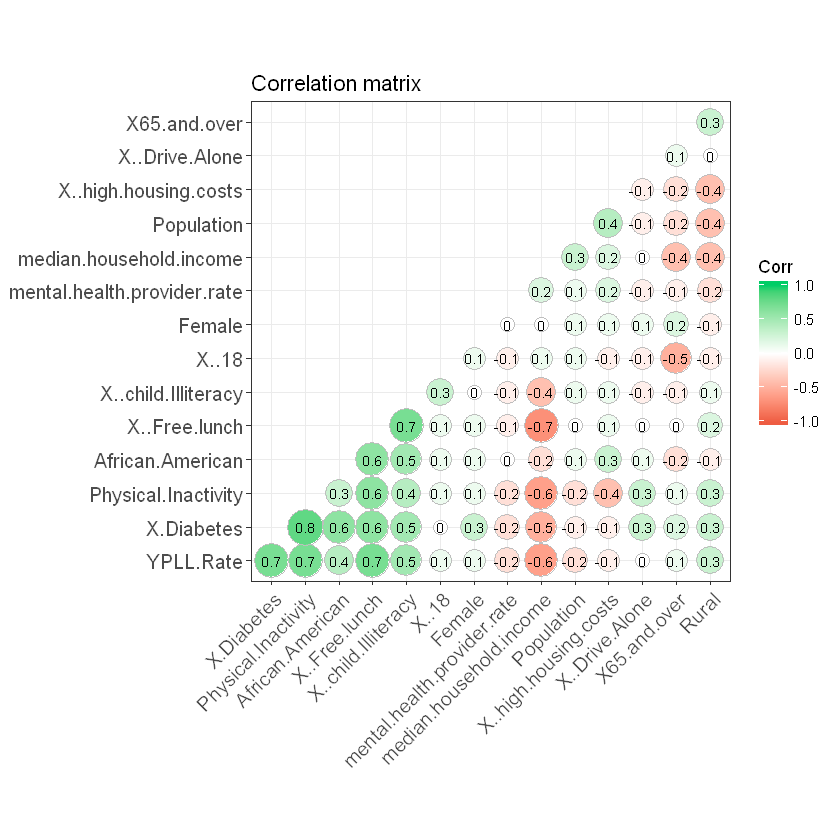

In [13]:
# select numeric columns
numVars <- names(which(sapply(df, is.numeric)))
# correlation matrix
corr <- round(cor(df[,numVars]), 1)
ggcorrplot(corr, hc.order = TRUE, 
           type = "lower", 
           lab = TRUE, 
           lab_size = 3, 
           method="circle", 
           colors = c("tomato2", "white", "springgreen3"), 
           title="Correlation matrix", 
           ggtheme=theme_bw)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


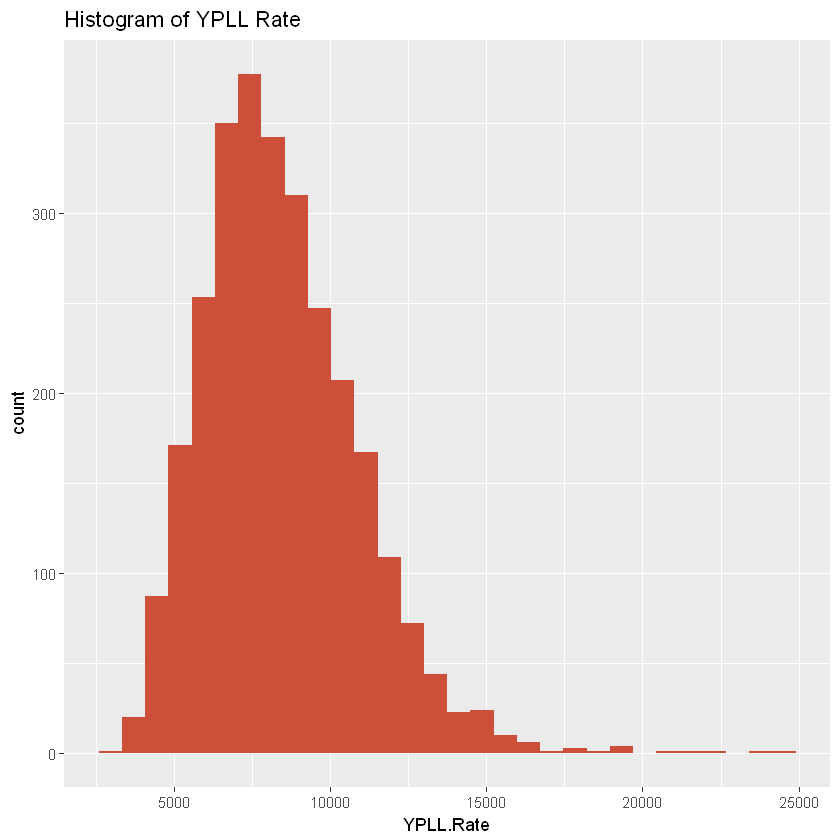

In [14]:
# Histogram
ggplot(df, aes(YPLL.Rate)) +  
  geom_histogram(fill="tomato3") +  
  labs(title="Histogram of YPLL Rate")
# not highly skewed. No need to scale. We can verify it later.

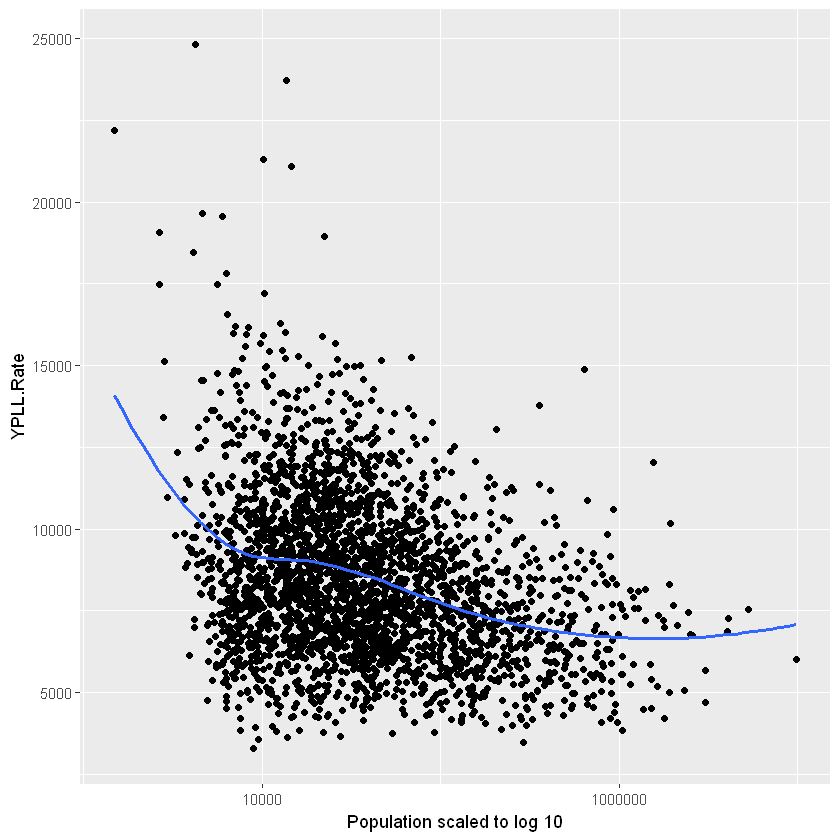

In [15]:
# Scatterplot
ggplot(df, aes(x=Population, y=YPLL.Rate)) + 
  geom_point() + 
  geom_smooth(method="loess", se=F) + scale_x_log10() +
  labs(x="Population scaled to log 10")
# Outliers

In [16]:
# Dummy HIV variable
df <- cbind(df, dummy(df$HIV))
df <- df[,!names(df) %in% "HIV"]

In [17]:
# Assign x y vars
yVar <- "YPLL.Rate"
xVars <- names(df[!names(df) %in% c(yVar)])

createModelFormula <- function(yVar, xVars, includeIntercept = TRUE){
  if(includeIntercept){
    modelForm <- as.formula(paste(yVar, "~", paste(xVars, collapse = '+ ')))
  } else {
    modelForm <- as.formula(paste(yVar, "~", paste(xVars, collapse = '+ '), -1))
  }
  return(modelForm)
}

In [21]:
# Fit linear model with all variables
modelForm <- createModelFormula(yVar = yVar, xVars = xVars, includeIntercept = FALSE)
modelForm
model <- lm(modelForm, data = df)
summary(model) 

YPLL.Rate ~ Population + X..18 + X65.and.over + African.American + 
    Female + Rural + X.Diabetes + Physical.Inactivity + mental.health.provider.rate + 
    median.household.income + X..high.housing.costs + X..Free.lunch + 
    X..child.Illiteracy + X..Drive.Alone + NAVeryLow + NALow + 
    NAHigh + NAVeryHigh + NANA - 1
<environment: 0x0000000022c9ee70>


Call:
lm(formula = modelForm, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-5076.9  -833.8   -95.6   705.1 11064.9 

Coefficients:
                                 Estimate    Std. Error t value
Population                    -0.00021906    0.00009676  -2.264
X..18                         87.86276811   11.97182726   7.339
X65.and.over                 -20.18209330   10.94826598  -1.843
African.American              -2.03624212    3.45369035  -0.590
Female                        -5.59661428   15.40356529  -0.363
Rural                          5.39630494    1.21619807   4.437
X.Diabetes                   307.54548665   26.33322345  11.679
Physical.Inactivity           83.59794555    9.53463728   8.768
mental.health.provider.rate   -0.99053873    0.44923676  -2.205
median.household.income       -0.04992777    0.00426563 -11.705
X..high.housing.costs          3.55465583    5.78602292   0.614
X..Free.lunch                 46.95881427    3.30803546  14.195
X..child.Illitera

In [22]:
# Test stepwise
model_step <- step(model, direction="both")
summary(model_step)

Start:  AIC=41251.92
YPLL.Rate ~ Population + X..18 + X65.and.over + African.American + 
    Female + Rural + X.Diabetes + Physical.Inactivity + mental.health.provider.rate + 
    median.household.income + X..high.housing.costs + X..Free.lunch + 
    X..child.Illiteracy + X..Drive.Alone + NAVeryLow + NALow + 
    NAHigh + NAVeryHigh + NANA - 1

                              Df Sum of Sq        RSS   AIC
- Female                       1    274998 5864353808 41250
- African.American             1    724125 5864802934 41250
- X..high.housing.costs        1    786242 5864865052 41250
<none>                                     5864078810 41252
- X65.and.over                 1   7078857 5871157667 41253
- mental.health.provider.rate  1  10127768 5874206578 41255
- Population                   1  10676710 5874755520 41255
- Rural                        1  41011509 5905090318 41270
- NAVeryLow                    1  71300732 5935379542 41284
- NANA                         1  73750466 5937829276


Call:
lm(formula = YPLL.Rate ~ Population + X..18 + X65.and.over + 
    Rural + X.Diabetes + Physical.Inactivity + mental.health.provider.rate + 
    median.household.income + X..Free.lunch + X..child.Illiteracy + 
    X..Drive.Alone + NAVeryLow + NALow + NAHigh + NAVeryHigh + 
    NANA - 1, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-5045.2  -834.0   -95.0   711.6 11140.8 

Coefficients:
                                 Estimate    Std. Error t value
Population                    -0.00020595    0.00009426  -2.185
X..18                         85.63552781   10.78369730   7.941
X65.and.over                 -20.69702141    9.97503399  -2.075
Rural                          5.33698621    1.17238290   4.552
X.Diabetes                   300.27083808   23.87080249  12.579
Physical.Inactivity           82.66839722    8.98952420   9.196
mental.health.provider.rate   -0.97929392    0.44605628  -2.195
median.household.income       -0.05013239    0.00421668 -11.889
X..Free.lu